# Part 0: Load in Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDR clusters

## 1.1 - Load in IDR information

In [3]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()



print(humandf)

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in ALBATROSS information

In [4]:
df1=pd.read_csv('data/All_sapiens_IDRs_1_20000_ALBATROSS.csv')
df2=pd.read_csv('data/All_sapiens_IDRs_20001_24508_ALBATROSS.csv')

albatrossdf=pd.concat([df1,df2],axis=0)
print(albatrossdf)

albuni=albatrossdf['fasta_header'].tolist()
albrg=albatrossdf['radius_of_gyration'].tolist()
alblen=albatrossdf['lengths'].tolist()
albscalexp=albatrossdf['scaling_exponent'].tolist()

fullalbatrossNormRg=[]
fullscalexp=[]
for i in range(0,len(fullaccswnums)):
    idx=albuni.index(fullaccswnums[i])
    fullalbatrossNormRg.append(albrg[idx]/np.sqrt(alblen[idx]))
    fullscalexp.append(albscalexp[idx])
    
print(fullalbatrossNormRg[0])
print(len(fullalbatrossNormRg))

      Unnamed: 0 fasta_header  lengths  radius_of_gyration  \
0              0     G5E9R7_1       53           24.443001   
1              1     Q9NRJ4_1       50           23.400517   
2              2     Q9NRJ4_2       43           19.119770   
3              3     Q9NRJ4_3       34           20.125533   
4              4     Q9NRJ4_4       36           18.128783   
...          ...          ...      ...                 ...   
4503        4503     Q7Z739_2      163           42.133990   
4504        4504     Q17RB8_1       31           15.312613   
4505        4505     Q17RB8_2       53           21.881011   
4506        4506     Q6P1J9_1       43           19.178411   
4507        4507     Q6P1J9_2       42           20.381902   

      end_to_end_distance  scaling_exponent  asphericity  prefactor  \
0               60.458677          0.573448     0.462206   6.957920   
1               57.301122          0.597782     0.467122   6.362150   
2               48.957815          0.57068

## 1.3 - Create data for boxplot

In [8]:
clusterRgdf=pd.DataFrame()
clusterRgdf['Gene']=fullgeneswnums
clusterRgdf['Uniprot w IDRnum']=fullaccswnums
clusterRgdf['Cluster Num']=fullclusternum
clusterRgdf['Normalized Rg']=fullalbatrossNormRg
clusterRgdf['Scaling exponent']=fullscalexp
clusterRgdf['IDR Length']=fullseqlens
clusterRgdf['IDR Position']=fulltermini
clusterRgdf['Min Inter Clust Dist']=fullmininterclustdist

# For all IDRs
#minidrlength=0
#minidrlinkerlength=0
#mininterclustdist=0

# For well-mapped IDRs >= 50 or linker >=70
minidrlength=50
minidrlinkerlength=70
mininterclustdist=1.5

clusterRgdf=clusterRgdf[clusterRgdf['IDR Length']>=minidrlength]
clusterRgdf=clusterRgdf[ (clusterRgdf['IDR Length']>=minidrlinkerlength) | (clusterRgdf['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
clusterRgdf=clusterRgdf[clusterRgdf['Min Inter Clust Dist']>=mininterclustdist]
print(len(clusterRgdf))

8560


Text(0.5, 0, 'GIN Cluster Number')

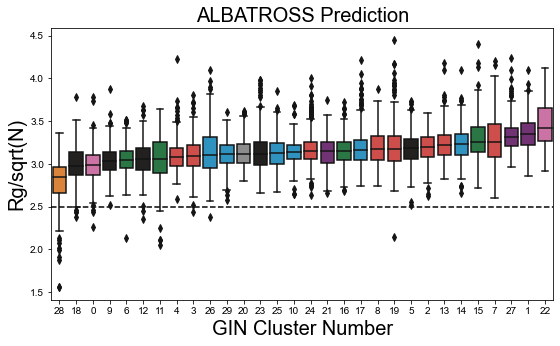

In [9]:
colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

grouped = clusterRgdf.loc[:,['Cluster Num', 'Normalized Rg']] \
    .groupby(['Cluster Num']) \
    .median() \
    .sort_values(by='Normalized Rg',ascending=True)

mypalette=[]
for i in range(0,len(grouped.index)):
    mypalette.append(colorhex[grouped.index[i]])

plt.figure(figsize=(9,5))
plt.plot([-0.5,30+0.5],[2.5,2.5],'--k')
sbn.boxplot(data=clusterRgdf,x='Cluster Num',y='Normalized Rg', order=grouped.index, palette=mypalette)

plt.title('ALBATROSS Prediction',fontsize=20)
plt.ylabel('Rg/sqrt(N)',fontsize=20)
plt.xlabel('GIN Cluster Number',fontsize=20)

Text(0.5, 0, 'GIN Cluster Number')

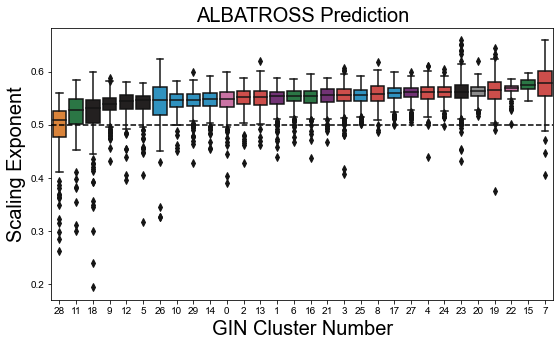

In [10]:
colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

grouped = clusterRgdf.loc[:,['Cluster Num', 'Scaling exponent']] \
    .groupby(['Cluster Num']) \
    .median() \
    .sort_values(by='Scaling exponent',ascending=True)

mypalette=[]
for i in range(0,len(grouped.index)):
    mypalette.append(colorhex[grouped.index[i]])

plt.figure(figsize=(9,5))
plt.plot([-0.5,30+0.5],[0.5,0.5],'--k')
sbn.boxplot(data=clusterRgdf,x='Cluster Num',y='Scaling exponent', order=grouped.index, palette=mypalette)

plt.title('ALBATROSS Prediction',fontsize=20)
plt.ylabel('Scaling Exponent',fontsize=20)
plt.xlabel('GIN Cluster Number',fontsize=20)

#plt.savefig('Figures/2024_02/ALBATROSS_scaling_exponent_by_cluster_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.pdf', transparent=True, bbox_inches = "tight") 


In [12]:
print(clusterRgdf)

#clusterRgdf.to_excel('all_human_IDRome_w_ALBATROSS_predictions.xlsx')

                 Gene Uniprot w IDRnum  Cluster Num  Normalized Rg  \
0      KRTAP4-16 IDR1         G5E9R7_1           27       3.357504   
1          TULP4 IDR1         Q9NRJ4_1           17       3.309333   
2          TULP4 IDR2         Q9NRJ4_2            1       2.915738   
3          TULP4 IDR3         Q9NRJ4_3           27       3.451500   
4          TULP4 IDR4         Q9NRJ4_4           27       3.021464   
...               ...              ...          ...            ...   
24503     YTHDF3 IDR2         Q7Z739_2           11       3.300189   
24504     LONRF1 IDR1         Q17RB8_1           29       2.750226   
24505     LONRF1 IDR2         Q17RB8_2           24       3.005588   
24506      CDC73 IDR1         Q6P1J9_1           17       2.924680   
24507      CDC73 IDR2         Q6P1J9_2           17       3.144996   

       Scaling exponent  IDR Length    IDR Position  Min Inter Clust Dist  
0              0.573448          53  C-terminal IDR              8.592811  
1      

In [36]:
print(grouped.var)

<bound method NDFrame._add_numeric_operations.<locals>.var of              Scaling exponent
Cluster Num                  
15                   0.000199
22                   0.000208
20                   0.000288
24                   0.000338
25                   0.000357
17                   0.000380
6                    0.000382
27                   0.000386
29                   0.000392
4                    0.000413
16                   0.000456
21                   0.000472
3                    0.000484
10                   0.000543
14                   0.000546
1                    0.000558
13                   0.000560
19                   0.000565
8                    0.000573
9                    0.000610
0                    0.000665
2                    0.000755
12                   0.000797
23                   0.000883
5                    0.001173
7                    0.001190
26                   0.001463
28                   0.001531
11                   0.002037
18      